In [1]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install imageio==2.4.0
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [79.8 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,257 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,750 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]     
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jam

In [4]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [5]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [6]:
tf.version.VERSION

'2.15.1'

# Hiperparámetros

In [8]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

# Medio Ambiente

In [25]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

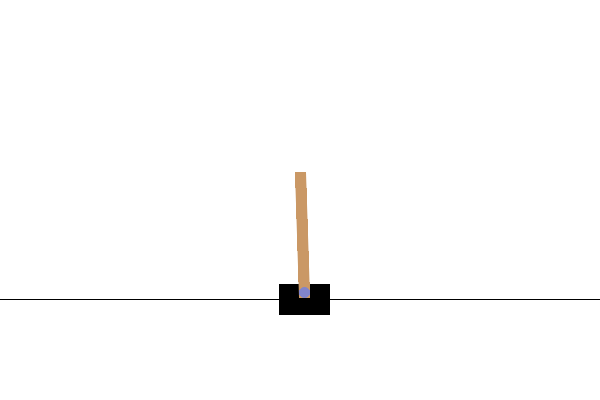

In [26]:
env.reset()
PIL.Image.fromarray(env.render())

In [27]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [28]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [29]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 0.04198623, -0.03833266,  0.03887642, -0.02726507], dtype=float32)})
Next time step:
TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(1., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 0.04121957,  0.15621084,  0.03833112, -0.307433  ], dtype=float32)})


In [30]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [33]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Agente

In [34]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

# Políticas

In [36]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [37]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [38]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

In [39]:
time_step = example_environment.reset()

In [40]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

# Métricas y Evaluación

In [41]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [42]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

33.1

# Búfer de reproducción

In [44]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpsvdj803r.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpsvdj803r
[reverb/cc/platform/default/server.cc:71] Started replay server on port 34659
[reverb/cc/platform/default/server.cc:84] Shutting down replay server


In [45]:
agent.collect_data_spec

Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})

In [46]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

# Recolección de datos

In [47]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(1., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': array([ 0.04110594,  0.9329503 , -0.16217545, -1.6046578 ], dtype=float32)}),
 ())

In [48]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [49]:
iterator = iter(dataset)
print(iterator)

# Entrenando el agente

In [50]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (35) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (35) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (35) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (35) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (35) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (35) so Table uniform_table is accessed directly without gRPC.


step = 200: loss = 12.524604797363281
step = 400: loss = 9.683467864990234
step = 600: loss = 72.73858642578125
step = 800: loss = 64.62853240966797
step = 1000: loss = 25.83981704711914
step = 1000: Average Return = 78.30000305175781
step = 1200: loss = 128.4234619140625
step = 1400: loss = 382.6611633300781
step = 1600: loss = 297.9491882324219
step = 1800: loss = 5331.6015625
step = 2000: loss = 314.58172607421875
step = 2000: Average Return = 200.0
step = 2200: loss = 1750.6175537109375
step = 2400: loss = 3497.108642578125
step = 2600: loss = 413.30108642578125
step = 2800: loss = 3268.3779296875
step = 3000: loss = 7108.56884765625
step = 3000: Average Return = 200.0
step = 3200: loss = 428.11212158203125
step = 3400: loss = 4769.8359375
step = 3600: loss = 7480.66015625
step = 3800: loss = 5114.31396484375
step = 4000: loss = 6601.57666015625
step = 4000: Average Return = 200.0
step = 4200: loss = 7868.494140625
step = 4400: loss = 6224.7646484375
step = 4600: loss = 7316.596191

# Visualización

(0.9199995994567871, 250.0)

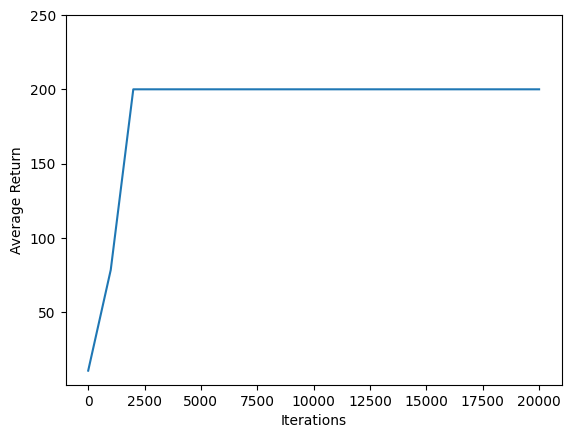

In [51]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [53]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [54]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

[swscaler @ 0x59bd667d4a00] Warning: data is not aligned! This can lead to a speed loss


In [55]:
create_policy_eval_video(random_policy, "random-agent")

[swscaler @ 0x5c96cd188a00] Warning: data is not aligned! This can lead to a speed loss


# Mejor arquitectura de deep learning (Pendulum)

La investigación sugiere que SAC (Soft Actor-Critic) es probablemente la mejor opción para el entorno Pendulum, debido a su eficiencia en espacios de acciones continuas y su capacidad para fomentar la exploración. Ya que maximiza la entropía y es eficiente en términos de muestras, ideal para tareas como Pendulum.

SAC (Soft Actor-Critic)
Tipo: Actor-crítico, off-policy, maximiza recompensa y entropía.
Espacio de acciones: Continuo.
Fortalezas: Maximiza tanto la recompensa esperada como la entropía, fomentando la exploración, lo cual es crucial para tareas como Pendulum donde el agente debe explorar para encontrar la posición vertical. Es off-policy, lo que lo hace eficiente en términos de muestras. Usa críticos gemelos como TD3 para estabilidad.
Debilidades: Puede ser más complejo de implementar y ajustar que PPO, especialmente el parámetro de temperatura para controlar la estocasticidad.
Evidencia: Encontrado en Stable Baselines3 SAC en Pendulum, con ejemplos de entrenamiento vectorizado. También en GitHub rl-pendulum, implementado junto con DQN, mostrando su uso común. En RL Zoo, tiene modelos pre-entrenados para Pendulum-v1, y en discusiones como Reddit sobre SAC vs PPO, se sugiere para entornos costosos en muestras, lo que incluye Pendulum. Además, en documentación de Stable Baselines3, se menciona como estado del arte para control continuo.